# GATK Somatic Copy Number Alteration Tutorial <a class="tocSkip">

**March 2023**  

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image1.July2019.png" alt="drawing" width="50%" align="left" style="margin:10px 20px"/> 
<font size=3>This hands-on tutorial outlines steps to sensitively detect alterations in total and allelic copy ratios using GATK4's ModelSegments CNA workflow. The workflow is suitable towards detecting somatic copy ratio alterations, more familiarly copy number alterations (CNAs) or copy number variants (CNVs), for whole genomes and targeted exomes.</font>


_This tutorial was last tested with the GATK v4.2.4.0 and IGV v2.8.0._
 See [GATK Tool Documentation](https://gatk.broadinstitute.org/hc/en-us/articles/360037224712) for further information on the tools we use below.


# Set up your Notebook


## Set cloud environment values
If you are opening a notebook for the first time today and you didn't adjust any runtime values, now's the time to edit them. Click on the gear icon in the upper right to edit your Notebook Runtime. Set the values as specified below:

| Option | Value |
| ------ | ------ |
| Environment | [Custom](https://github.com/broadinstitute/gatk-workshop-terra-jupyter-image/wiki/Using-the-gatk%E2%80%90workshop%E2%80%90terra%E2%80%90jupyter%E2%80%90image-in-the-Terra-Jupyter-environment#6-type-the-command-setup_gatk_env-in-the-terminal-and-hit-enter) |
| Profile | Custom |
| CPU | 4 |
| Disk size | 100 GB |
| Memory | 15 GB |

**Please Note:** This notebook currently requires the use of a custom environment, as described [here](https://github.com/broadinstitute/gatk-workshop-terra-jupyter-image/wiki/Using-the-gatk%E2%80%90workshop%E2%80%90terra%E2%80%90jupyter%E2%80%90image-in-the-Terra-Jupyter-environment#6-type-the-command-setup_gatk_env-in-the-terminal-and-hit-enter).

Click the "create"/"Update" button when you are done, and Terra will begin to create a new runtime with your settings. When it is finished, it will pop up asking you to apply the new settings. In the meantime, you can continue with the setup instructions below. 

## Setup the GATK conda environment

Run the following commands in the Terra terminal (available from the right panel):

```
setup_gatk_env
```

When you are done, you should close this notebook and reopen.

## Check kernel type selected in the Jupyter notebook
For this particular notebook, we will be using a specialized kernel that we've added to our **Kernel** menu by following the previous two steps for creating the custom envrionemnt. If you've successfully done this, you should be able to select a kernel called `Python [conda env:gatkconda]`under the **Kernel** > **Change Kernel** menu.

## Set up your files
Your notebook has a temporary folder that exists so long as your cluster is running. To see what files are in your notebook environment at any time, you can click on the Jupyter logo in the upper left corner. 

For this tutorial, we need to copy some files from this temporary folder to and from our workspace bucket. Run the two commands below to set up the workspace bucket variable and the file paths inside your notebook.

<font color = "green"> **Tool Tip:** To run a cell in a notebook, press `SHIFT + ENTER`</font>

In [1]:
# Set your workspace bucket variable for this notebook.
import os
BUCKET = os.environ['WORKSPACE_BUCKET']

In [2]:
# Set workshop variable to access the most recent materials
WORKSHOP = "workshop_2002"

In [3]:
# Create sandbox and file directories
! mkdir -p /home/jupyter/notebooks/3-somatic-cna/sandbox/
! mkdir -p /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/
! mkdir -p /home/jupyter/notebooks/3-somatic-cna/ref/
! mkdir -p /home/jupyter/notebooks/3-somatic-cna/cna_inputs

# Removes any old symbolic linked sandbox directory and adds a new link, in case you've run this before
! rm -rf sandbox
! ln -s /home/jupyter/notebooks/3-somatic-cna/sandbox sandbox

In [4]:
# Adds Display function for viewing images from the notebook folder. We will use this to look
# at the outputs at different steps in this pipeline
from IPython.display import display, Image

## Check data permissions
For this tutorial, we have hosted the starting files in a public Google bucket. We will first check that the data is available to your user account, and if it is not, we simply need to install Google Cloud Storage.

In [5]:
# Check if data is accessible. The command should list several gs:// URLs.
! gsutil ls gs://gatk-tutorials/$WORKSHOP/3-somatic/

gs://gatk-tutorials/workshop_2002/3-somatic/.DS_Store
gs://gatk-tutorials/workshop_2002/3-somatic/bams/
gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/
gs://gatk-tutorials/workshop_2002/3-somatic/cna_plots/
gs://gatk-tutorials/workshop_2002/3-somatic/cna_precomputed/
gs://gatk-tutorials/workshop_2002/3-somatic/mutect2_precomputed/
gs://gatk-tutorials/workshop_2002/3-somatic/ref/
gs://gatk-tutorials/workshop_2002/3-somatic/resources/
gs://gatk-tutorials/workshop_2002/3-somatic/sandbox/


In [6]:
# If you do not see gs:// URLs listed above, run this cell to install Google Cloud Storage. 
# Afterwards, restart the kernel with Kernel > Restart.
#! pip install google-cloud-storage

## Download Data to the Notebook 
Some tools are not able to read directly from a Google bucket, so we download their files to our local notebook folder.

In [7]:
! gsutil cp gs://gatk-tutorials/$WORKSHOP/3-somatic/cna_inputs/* /home/jupyter/notebooks/3-somatic-cna/cna_inputs/
! gsutil cp gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.dict /home/jupyter/notebooks/3-somatic-cna/ref/
    

Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/.DS_Store...
Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/cnaponC.pon.hdf5...
Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/hcc1143_N_clean.allelicCounts.tsv...
Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/hcc1143_N_clean.counts.hdf5...
/ [4 files][300.7 MiB/300.7 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/hcc1143_T_clean.allelicCounts.tsv...
Copying gs://gatk-tutorials/workshop_2002/3-somatic/cna_inputs/hcc1143_T_clean.counts.hdf5...
- [6 files][506.2 MiB/506.2 MiB]                                                
Operation completed over 6 objects/506.

---

# PERFORM COVERAGE ANALYSIS: MODELSEGMENTS CNA

## Prepare intervals for coverage collection
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image3.July2019.png" alt="drawing" width="300" align="right" style="margin:0px 20px"/> 
Collecting coverage counts forms the basis of copy number variant detection. However, before we can do that, we must define the resolution of the analysis with a genomic intervals list. Since we are using exome data, we will pad the target regions. Padding target regions 250 bases on each side has been shown to increase sensitivity for the CNA workflow. In the case of whole genome data, we would divide the reference genome into equally sized intervals or bins. In either case, we use PreprocessIntervals to prepare the intervals list.
 
The `--bin-length` value must be set for different data types, e.g. default 1000 for whole genome or 0 for exomes. For the tutorial exome data, we provide a snippet of the capture kit target regions and set --bin-length to zero.

In [8]:
 ! gatk PreprocessIntervals \
    -L gs://gatk-tutorials/$WORKSHOP/3-somatic/resources/targets_chr17.interval_list \
    -R gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.fasta \
    --padding 250 \
    --bin-length 0 \
    --interval-merging-rule OVERLAPPING_ONLY \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PreprocessIntervals -L gs://gatk-tutorials/workshop_2002/3-somatic/resources/targets_chr17.interval_list -R gs://gatk-tutorials/workshop_2002/3-somatic/ref/Homo_sapiens_assembly38.fasta --padding 250 --bin-length 0 --interval-merging-rule OVERLAPPING_ONLY -O /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list
18:29:00.346 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:29:00.409 INFO  PreprocessIntervals - ------------------------------------------------------------
18:29:00.413 INFO  PreprocessIntervals - The Genome Analysis Toolkit (GATK) v4.4

This produces a Picard-style intervals list targets_chr17.preprocessed.interval_list with 11,307 targets for use in the coverage collection step.

➤ Peruse both the before and after intervals. Do we have the same number of intervals as before? How does the tool pad intervals that are less than 500bp apart?  
➤ Take a look at the tool doc description for `-imr OVERLAPPING_ONLY` [here](https://gatk.broadinstitute.org/hc/en-us/articles/4405443672347-PreprocessIntervals#--interval-merging-rule). What does this option ensure?

In [9]:
!gsutil cat gs://gatk-tutorials/$WORKSHOP/3-somatic/resources/targets_chr17.interval_list | egrep -v "^@" | wc -l
    

11307


In [10]:
!egrep -v "^@" /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list | wc -l


11307


In [11]:
!gsutil cat gs://gatk-tutorials/workshop_1910/3-somatic/resources/targets_chr17.interval_list | egrep -v "^@" | awk '{$6=$3-$2;print}' | head
    

chr17 213850 213925 + target_146723_RPH3AL 75
chr17 215652 215804 + target_146724_RPH3AL 152
chr17 219621 219738 + target_146725_RPH3AL 117
chr17 247109 247287 + target_146726_RPH3AL 178
chr17 281766 281856 + target_146727_RPH3AL 90
chr17 319418 319551 + target_146728_RPH3AL 133
chr17 321270 321417 + target_146729_RPH3AL 147
chr17 327465 327545 + target_146730_RPH3AL 80
chr17 410341 410648 + target_146731_C17orf97 307
chr17 413146 414117 + target_146732_C17orf97 971
awk: write failure (Broken pipe)
awk: close failed on file /dev/stdout (Broken pipe)
grep: write error: Broken pipe


In [12]:
!grep -v "^@" /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list | awk '{$6=$3-$2;print}' | head


chr17 213600 214175 + . 575
chr17 215402 216054 + . 652
chr17 219371 219988 + . 617
chr17 246859 247537 + . 678
chr17 281516 282106 + . 590
chr17 319168 319801 + . 633
chr17 321020 321667 + . 647
chr17 327215 327795 + . 580
chr17 410091 410898 + . 807
chr17 412896 414367 + . 1471
awk: write failure (Broken pipe)
awk: close failed on file /dev/stdout (Broken pipe)
grep: write error: Broken pipe


---
## Collect read counts for samples across target intervals

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image4.July2019.png" alt="drawing" width="300" align="right" style="margin:0px 20px"/> 

The basis for detecting amplification and deletion events from sequencing data is read coverage. In this step, we count the number of read starts that overlap each interval using CollectReadCounts. We perform this step for the tumor sample and for the normal sample.

By default, the tool writes [HDF5 format](https://software.broadinstitute.org/gatk/documentation/article?id=11508) data, which is handled more efficiently by downstream tools (decreases runtime by reducing time spent on IO). Here we change the output format to TSV for teaching purposes. 

In [13]:
! gatk CollectReadCounts \
    -I gs://gatk-tutorials/$WORKSHOP/3-somatic/bams/tumor.bam \
    -L /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list \
    -R gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.fasta \
    --format TSV \
    -imr OVERLAPPING_ONLY \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/tumor.counts.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CollectReadCounts -I gs://gatk-tutorials/workshop_2002/3-somatic/bams/tumor.bam -L /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list -R gs://gatk-tutorials/workshop_2002/3-somatic/ref/Homo_sapiens_assembly38.fasta --format TSV -imr OVERLAPPING_ONLY -O /home/jupyter/notebooks/3-somatic-cna/sandbox/tumor.counts.tsv
18:29:55.534 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:29:55.579 INFO  CollectReadCounts - ------------------------------------------------------------
18:29:55.583 INFO  CollectReadCounts - The Genome Analysis Toolkit (GATK) v4

In [14]:
! gatk CollectReadCounts \
    -I gs://gatk-tutorials/$WORKSHOP/3-somatic/bams/normal.bam \
    -L /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list \
    -R gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.fasta \
    --format TSV \
    -imr OVERLAPPING_ONLY \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.counts.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CollectReadCounts -I gs://gatk-tutorials/workshop_2002/3-somatic/bams/normal.bam -L /home/jupyter/notebooks/3-somatic-cna/sandbox/targets_chr17.preprocessed.interval_list -R gs://gatk-tutorials/workshop_2002/3-somatic/ref/Homo_sapiens_assembly38.fasta --format TSV -imr OVERLAPPING_ONLY -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.counts.tsv
18:30:18.528 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:30:18.586 INFO  CollectReadCounts - ------------------------------------------------------------
18:30:18.590 INFO  CollectReadCounts - The Genome Analysis Toolkit (GATK) 

Here we show the raw counts per target (y-axis) for the normal and the tumor across 23 chromosomes (x-axis). Each target is represented by a point.
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/cna-image1.png" alt="drawing" width="1000"/>
➤ Can you tell if either sample has copy number variants?

---
## Create a 1-sample panel of normals (PoN)

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image5.July2019.png" alt="drawing" width="300" align="right" style="margin:0px 20px"/> 

Now we generate the CNA PoN with CreateReadCountPanelOfNormals. The tool creates a panel of normals that forms the baseline for what is the norm against which the workflow compares case samples. The tool uses Singular Value Decomposition, a type of Principal Component Analysis to capture systematic noise against statistical noise.

Normally, you will want to create a PoN with some number of **normal samples that were ideally subject to the same batch effects as your case sample** under scrutiny. This tutorial will use a PoN made of forty 1KGP normal samples and generated with the following command: 

```
gatk --java-options "-Xmx6500m" CreateReadCountPanelOfNormals \
    -I file1_clean.counts.hdf5 \
    … 
    -I file40_clean.counts.hdf5 \
    -O cnaponC.pon.hdf5
```

CreateReadCountPanelOfNormals performs several other filtering steps across samples and across targets, and [this article section](https://gatk.broadinstitute.org/hc/en-us/articles/4405443742491-CreateReadCountPanelOfNormals) outlines these.

**At the least, the PoN should consist of 10 normal samples** that were ideally subject to the same batch effects as that of the tumor sample. Our **recommendation is 40 or more normal samples**. To illustrate tool features, we create a PoN with our normal sample with the following command.

In [15]:
#For multiple samples, the -I would be specified multiple times
! gatk CreateReadCountPanelOfNormals \
    -I /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.counts.tsv \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.pon.hdf5

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CreateReadCountPanelOfNormals -I /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.counts.tsv -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.pon.hdf5
18:30:37.519 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:30:37.580 INFO  CreateReadCountPanelOfNormals - ------------------------------------------------------------
18:30:37.585 INFO  CreateReadCountPanelOfNormals - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:30:37.585 INFO  CreateReadCountPanelOfNormals - For support and documentation go to https://software.broadinstitute.org/gatk/
18:30:37.586 INFO  CreateReadC

➤ Study the stdout. 

**Are we losing any data during the filtering steps?** 

Given the reasons one might want to use a matched normal, **would you change this command?** 

Remember also __PoN medians are used to standardize case counts (by dividing)__.

So far we have been using subset data.

## Run CreateReadCountPanelOfNormals 

Run the command using the full data file cna_inputs/hcc1143_N_clean.counts.hdf5. Here we have adjusted the parameters to include `--minimum-interval-median-percentile`.

Changing the --minimum-interval-median-percentile argument from the default of 10.0 to a smaller value of 5.0 allows retention of more data, which is appropriate for this carefully selected normals cohort.

In [16]:
! gatk CreateReadCountPanelOfNormals \
    -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.counts.hdf5 \
    --minimum-interval-median-percentile 5.0 \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.pon.hdf5

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CreateReadCountPanelOfNormals -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.counts.hdf5 --minimum-interval-median-percentile 5.0 -O /home/jupyter/notebooks/3-somatic-cna/sandbox/normal.pon.hdf5
18:30:44.111 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:30:44.160 INFO  CreateReadCountPanelOfNormals - ------------------------------------------------------------
18:30:44.164 INFO  CreateReadCountPanelOfNormals - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:30:44.164 INFO  CreateReadCountPanelOfNormals - For support and documentation go to https://software.b

➤ Which do you think will perform better in revealing copy number events in the tumor, the 40-sample PoN or the matched-normal? Why?

If you are curious to see for yourself how the matched-normal PoN pans out, it is possible to substitute it in to the remaining steps. Instructions continue with the 40-sample PoN.

---
## Remove noise from sample coverage using the PoN

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image6.July2019.png" alt="drawing" width="300" align="right" style="margin:0px 20px"/>

&nbsp;

We use DenoiseReadCounts and the PoN to standardize and then denoise sample read counts. 

This produces two files, the standardized copy ratios hcc1143_T_clean.standardizedCR.tsv and the denoised copy ratios hcc1143_T_clean.denoisedCR.tsv that each represents a data transformation. In the first transformation, the tool standardizes counts by the PoN median counts. The standarization includes log2 transformation and normalizing the counts data to center around one. In the second transformation, the tool denoises the standardized copy ratios using the principal components of the PoN.

In the single-sample-PoN case, the two results will be identical to each other, as the tool only performs standardization.  

### Denoise Read Counts

In [17]:
! gatk --java-options "-Xmx7g -DGATK_STACKTRACE_ON_USER_EXCEPTION=true" DenoiseReadCounts \
    -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.counts.hdf5 \
    --count-panel-of-normals /home/jupyter/notebooks/3-somatic-cna/cna_inputs/cnaponC.pon.hdf5 \
    --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.standardizedCR.tsv \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -DGATK_STACKTRACE_ON_USER_EXCEPTION=true -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar DenoiseReadCounts -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.counts.hdf5 --count-panel-of-normals /home/jupyter/notebooks/3-somatic-cna/cna_inputs/cnaponC.pon.hdf5 --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.standardizedCR.tsv --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv
18:30:51.278 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:30:51.326 INFO  DenoiseReadCounts - --------------------------------------------

In [18]:
! gatk --java-options "-Xmx7g" DenoiseReadCounts \
    -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.counts.hdf5 \
    --count-panel-of-normals /home/jupyter/notebooks/3-somatic-cna/cna_inputs/cnaponC.pon.hdf5 \
    --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.standardizedCR.tsv \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar DenoiseReadCounts -I /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.counts.hdf5 --count-panel-of-normals /home/jupyter/notebooks/3-somatic-cna/cna_inputs/cnaponC.pon.hdf5 --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.standardizedCR.tsv --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv
18:30:57.703 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:30:57.751 INFO  DenoiseReadCounts - ------------------------------------------------------------
18:30:57.755 INFO  Denoi

➤ Skim the stdout to get a sense of the data transformations during standardization vs. denoising. 

The tool uses the maximum number of eigensamples available in the PoN. Changing the `--number-of-eigensamples` in DenoiseReadCounts to lower values can change the resolution of results, i.e. how smooth segments are. Using a larger number of principal components will result in a higher level of denoising and a larger difference in the MADs. The level of denoising should be chosen with some care, as it will ultimately affect the sensitivity of the analysis.

### Plot Denoised Copy Ratios 
Let's take a look at the data in its current state.

In [19]:
! gatk PlotDenoisedCopyRatios \
    --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.standardizedCR.tsv \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output-prefix hcc1143_T_clean \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotDenoisedCopyRatios --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.standardizedCR.tsv --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output-prefix hcc1143_T_clean -O /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots
18:31:04.237 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:31:04.293 INFO  PlotDenoisedCopyRatios - ------------------------------------

View the plot by running the cell below.

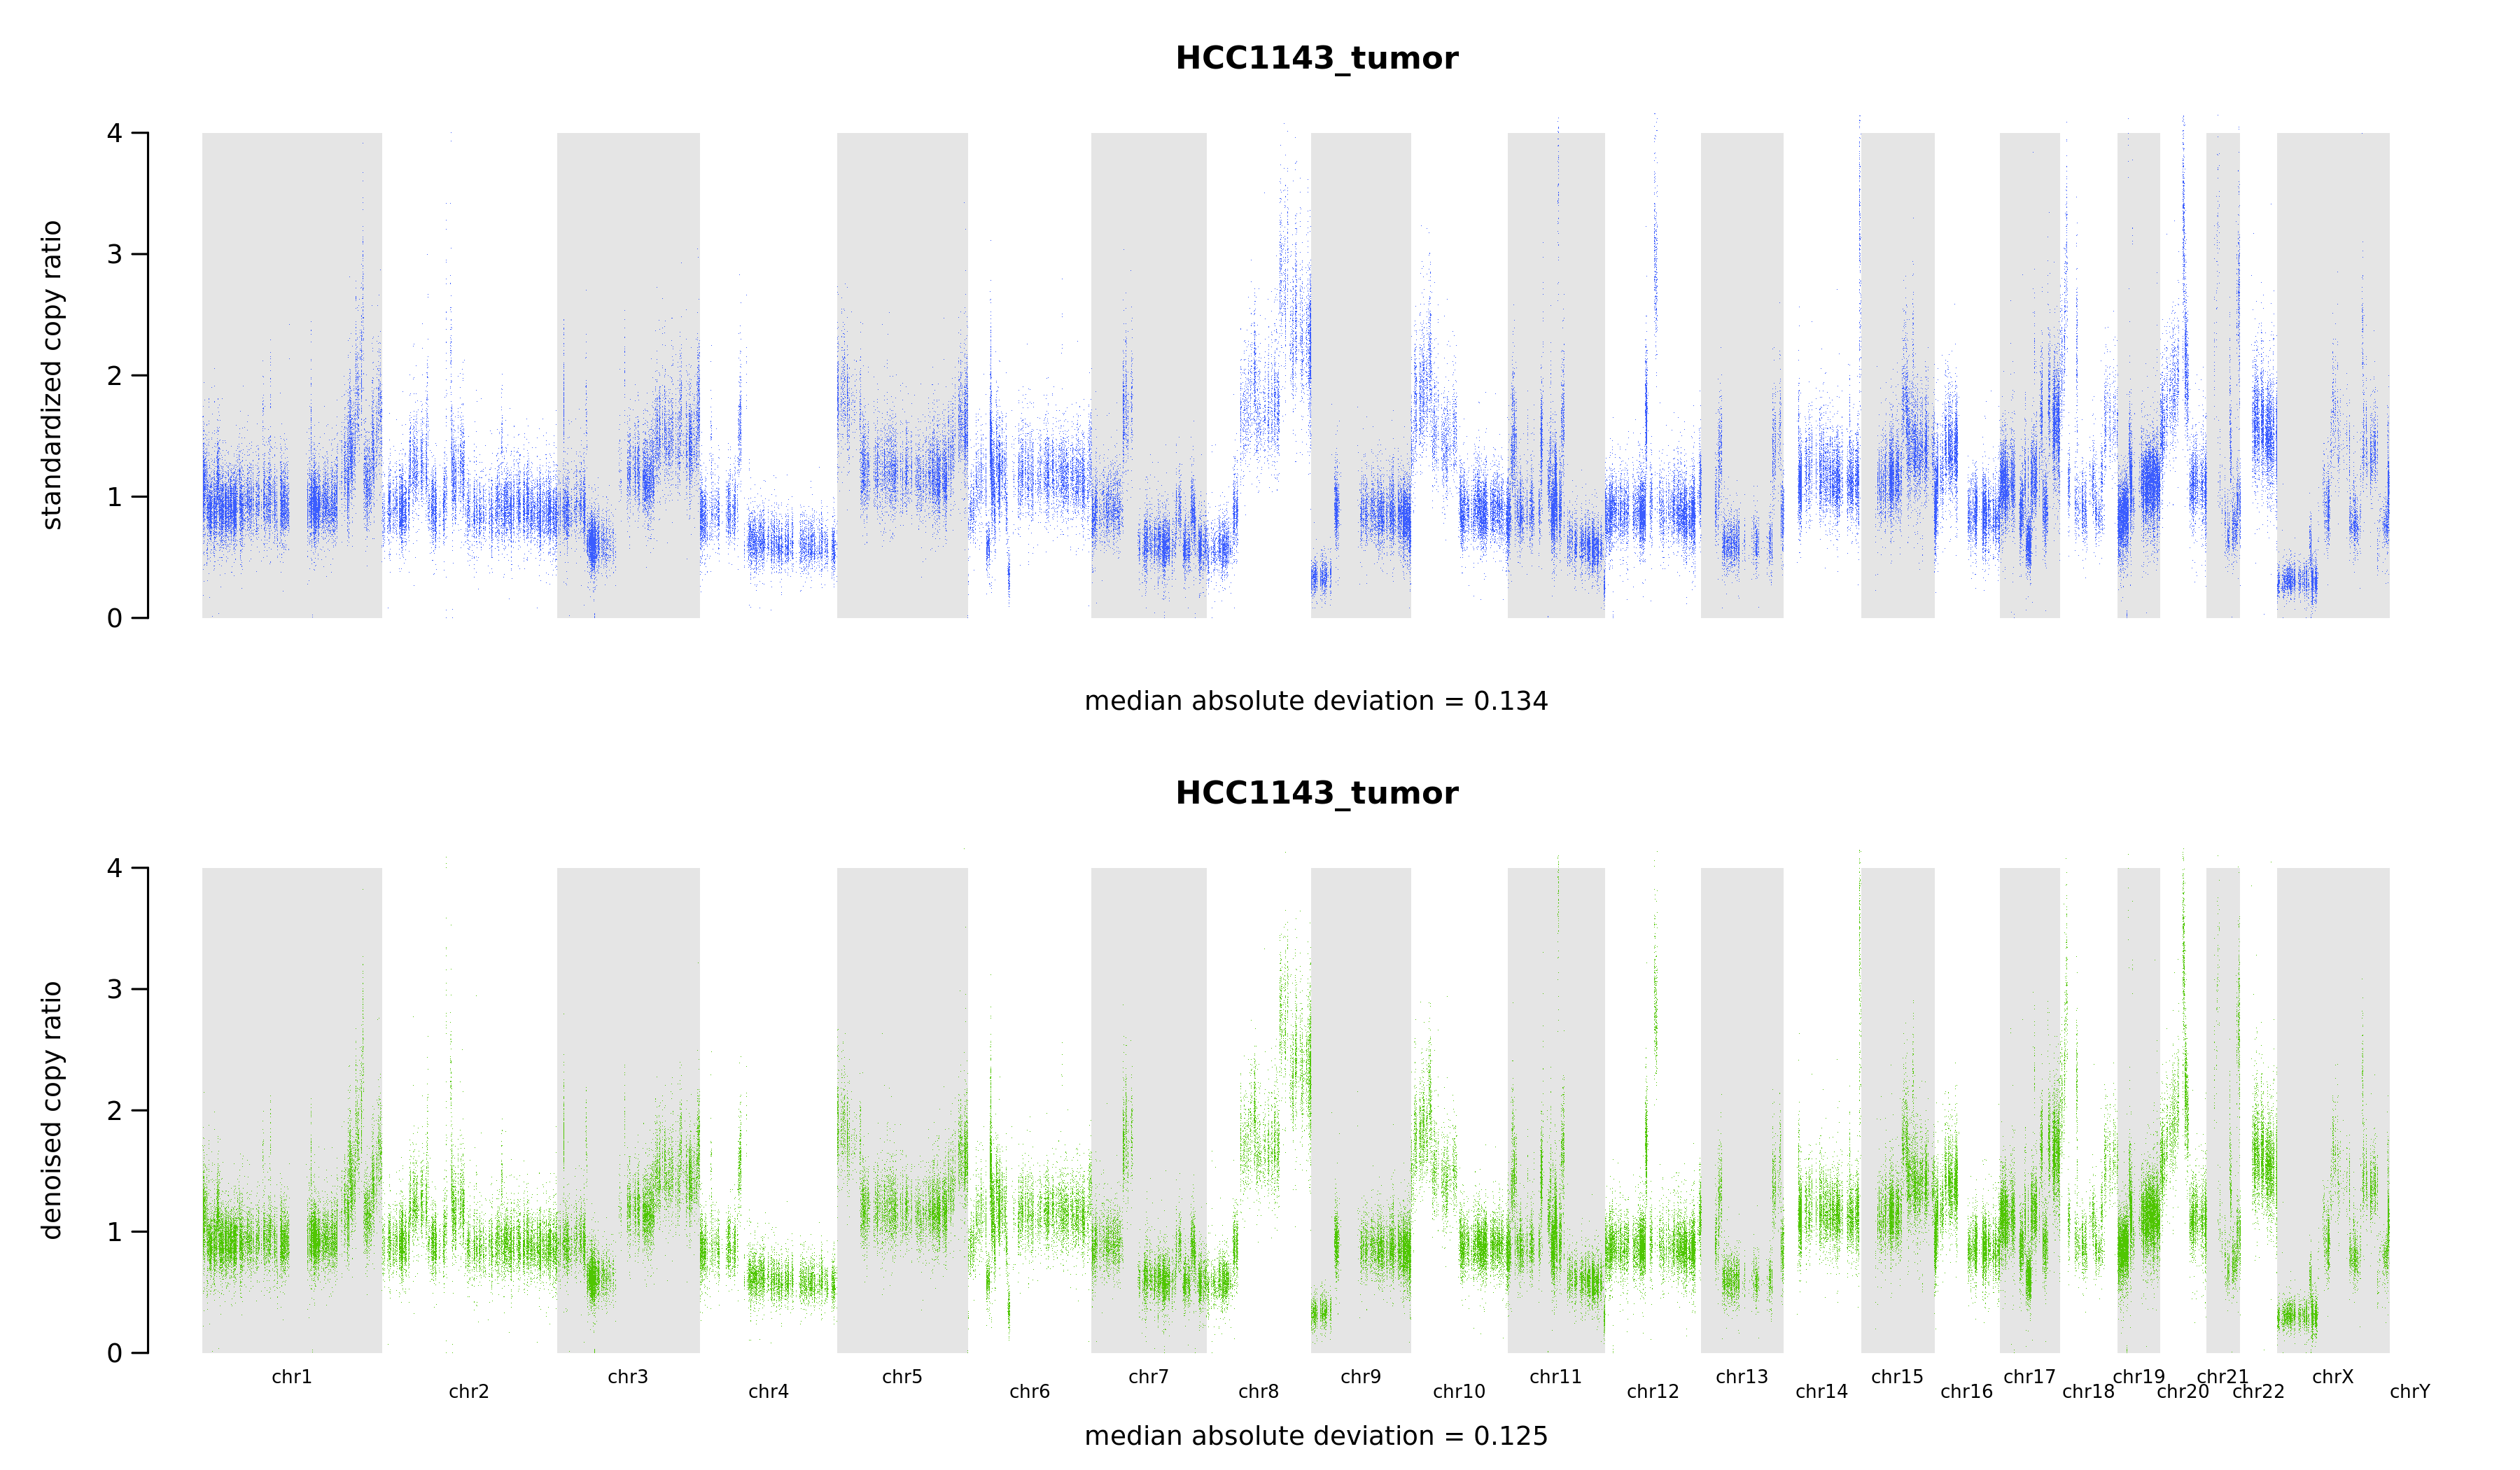

In [20]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_T_clean.denoised.png'))

In [21]:
! gatk PlotDenoisedCopyRatios \
    --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.standardizedCR.tsv \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots \
    --output-prefix hcc1143_N_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotDenoisedCopyRatios --standardized-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.standardizedCR.tsv --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots --output-prefix hcc1143_N_clean
18:31:11.385 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:31:11.439 INFO  PlotDenoisedCopyRatios - ------------------------------

View the plot by running the cell below.

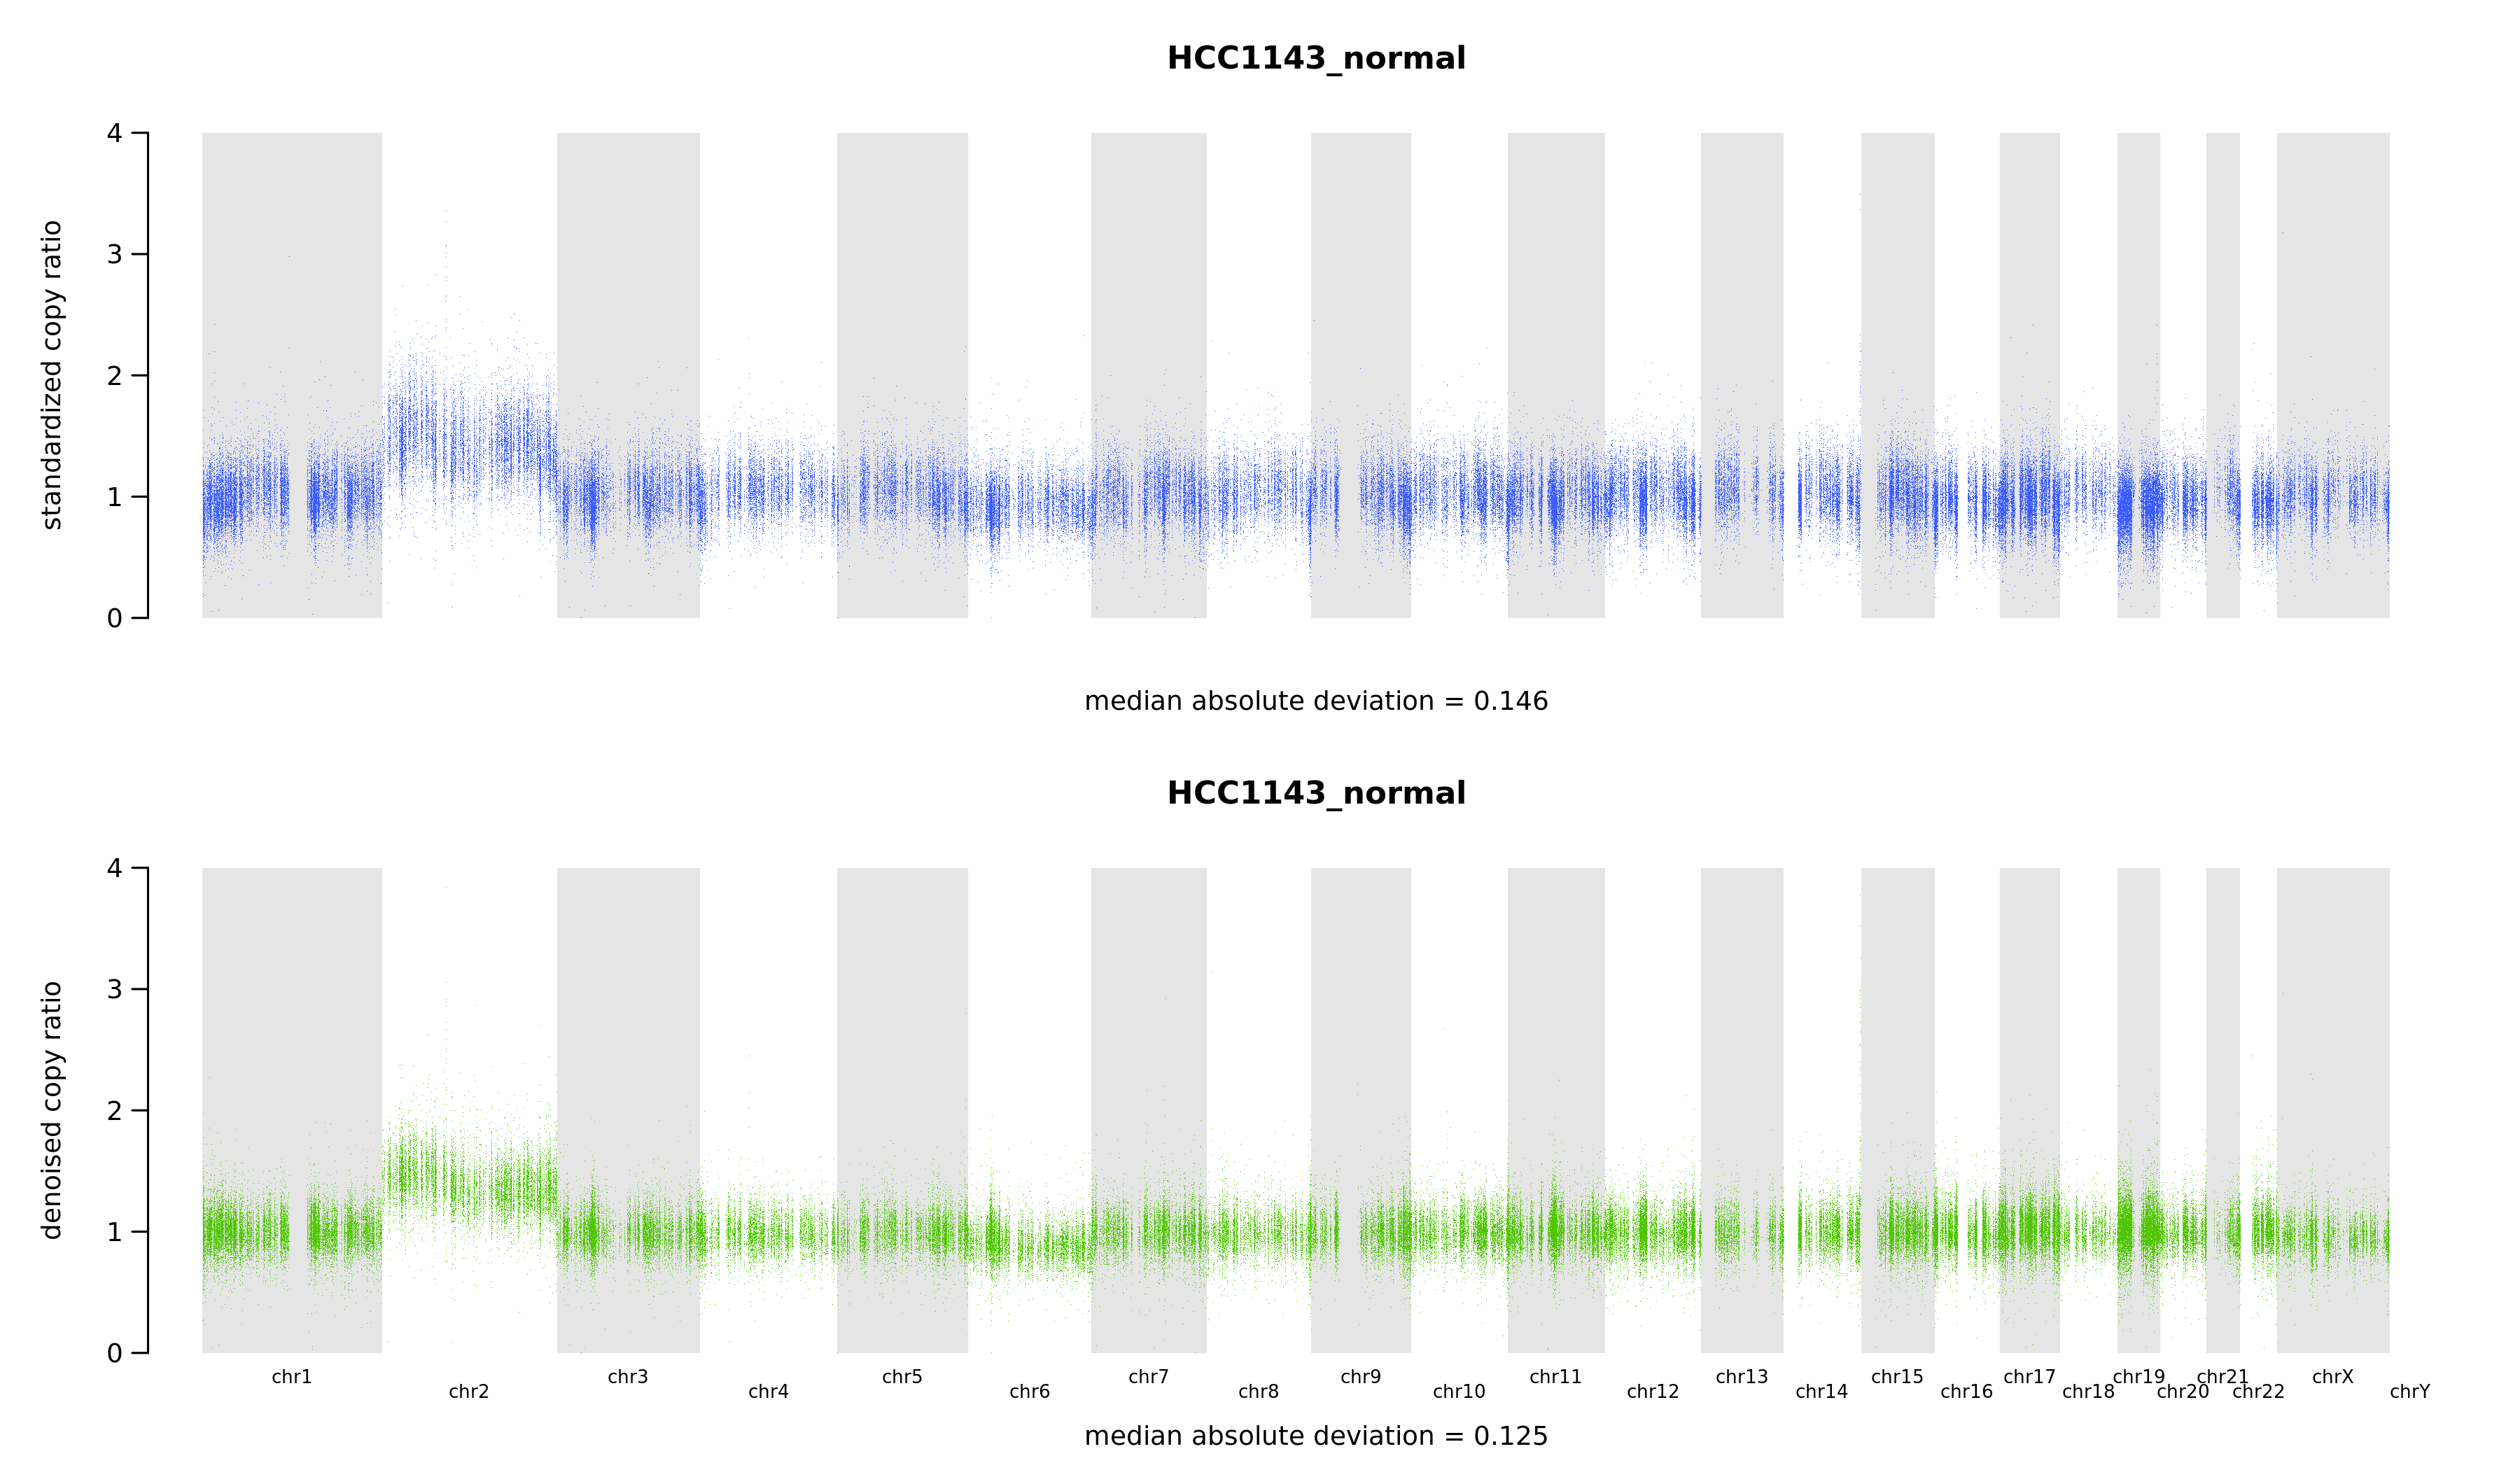

In [22]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_N_clean.denoised.png'))

➤ Skim the stdout to get a sense of the data transformations during standardization and denoising. 

Each command produces two sets of data: plots and QC values. 
- In the plots, standardized copy ratios are shown in blue. Standardization involves median-centering and log-transformation. Denoised copy ratios are in green. Denoising is performed using the principal components of the PoN. 
- The QC values pertain to the median-absolute-deviation (MAD) in different contexts, including the change between standardized and denoised (.deltaMAD.txt)  and the change between the two scaled by the standardized MAD (.deltaScaledMAD.txt).

| &nbsp; | &nbsp; |
| --- | --- |
| <img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image2.png" alt="drawing" width="500"/> | <img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image3.png" alt="drawing" width="500"/> |

---


## Perform segmentation based on coverage alone

At the heart of the GATK4 CNA workflow is ModelSegments, a tool that groups contiguous copy ratios into segments. Either or both copy ratios and allelic copy ratios inform segmentation. So far, the tutorial has focused only on coverage data. So let's see what segmentation with coverage alone looks like.

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image7.July2019.png" alt="drawing" width="800" align="left" style="margin:0px 20px"/> 




### Model segments on coverage alone 

In [23]:
! gatk --java-options "-Xmx7g" ModelSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox  \
    --output-prefix hcc1143_T_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar ModelSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv --output /home/jupyter/notebooks/3-somatic-cna/sandbox --output-prefix hcc1143_T_clean
18:31:18.335 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:31:18.392 INFO  ModelSegments - ------------------------------------------------------------
18:31:18.397 INFO  ModelSegments - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:31:18.397 INFO  ModelSegments - For support and documentation go to https://software.broadinstitute.org/gatk/
18:31:18.398 INFO  ModelSegments

In [24]:
! gatk --java-options "-Xmx7g" ModelSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox  \
    --output-prefix hcc1143_N_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar ModelSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv --output /home/jupyter/notebooks/3-somatic-cna/sandbox --output-prefix hcc1143_N_clean
18:32:08.211 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:32:08.271 INFO  ModelSegments - ------------------------------------------------------------
18:32:08.276 INFO  ModelSegments - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:32:08.276 INFO  ModelSegments - For support and documentation go to https://software.broadinstitute.org/gatk/
18:32:08.277 INFO  ModelSegments

Each command produces nine files.

### Plot Modeled Segments
Let's see what modeling segments on coverage alone looks like. Here we provide a second plotting tool, PlotModeledSegments, with the denoised copy ratios (from DenoiseReadCounts), the segments (from ModelSegments), and the reference sequence dictionary. 

In [25]:
! gatk PlotModeledSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv \
    --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.modelFinal.seg \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots \
    --output-prefix hcc1143_T_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotModeledSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.modelFinal.seg --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots --output-prefix hcc1143_T_clean
18:32:54.085 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:32:54.129 INFO  PlotModeledSegments - --------------------------------------------------------

View the plot generated from the previous command by running the Markdown cell below.

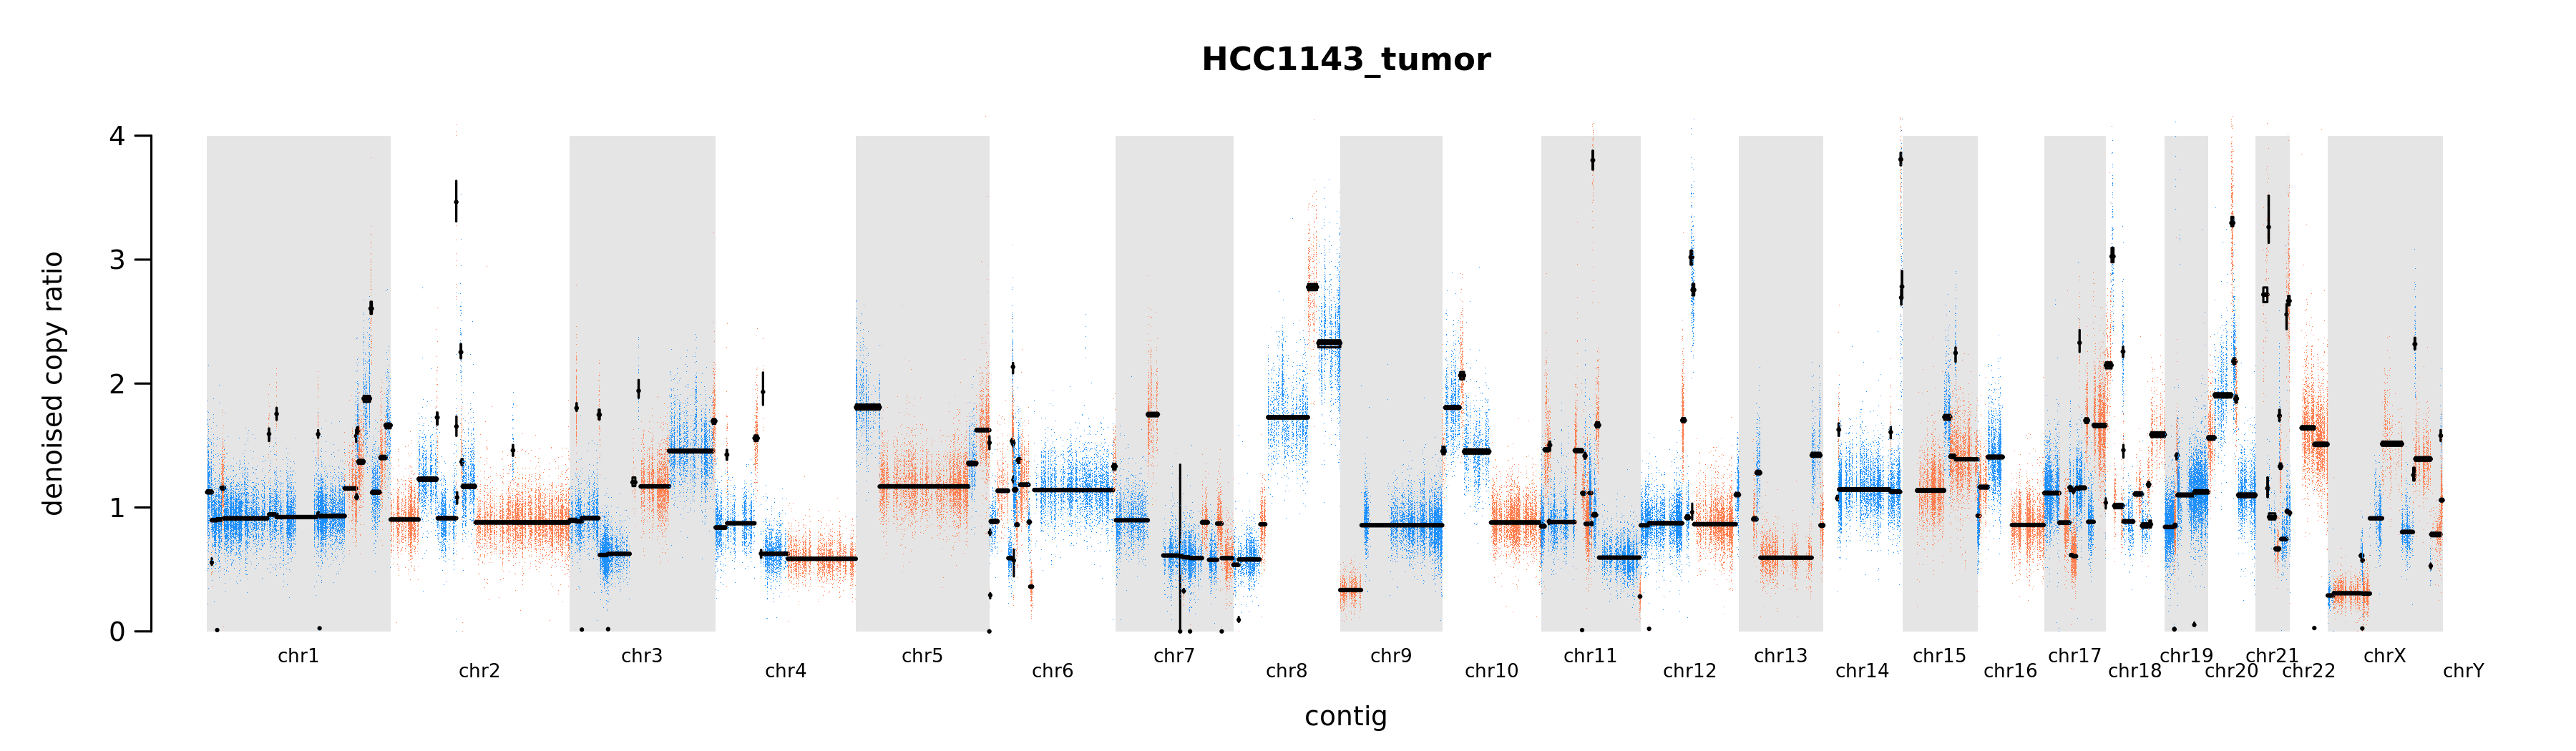

In [26]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_T_clean.modeled.png'))

In [27]:
! gatk PlotModeledSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv \
    --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.modelFinal.seg \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots \
    --output-prefix hcc1143_N_clean


Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotModeledSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.denoisedCR.tsv --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.modelFinal.seg --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots --output-prefix hcc1143_N_clean
18:33:00.450 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:33:00.507 INFO  PlotModeledSegments - --------------------------------------------------------

View the plot generated from the previous command by running the cell below.

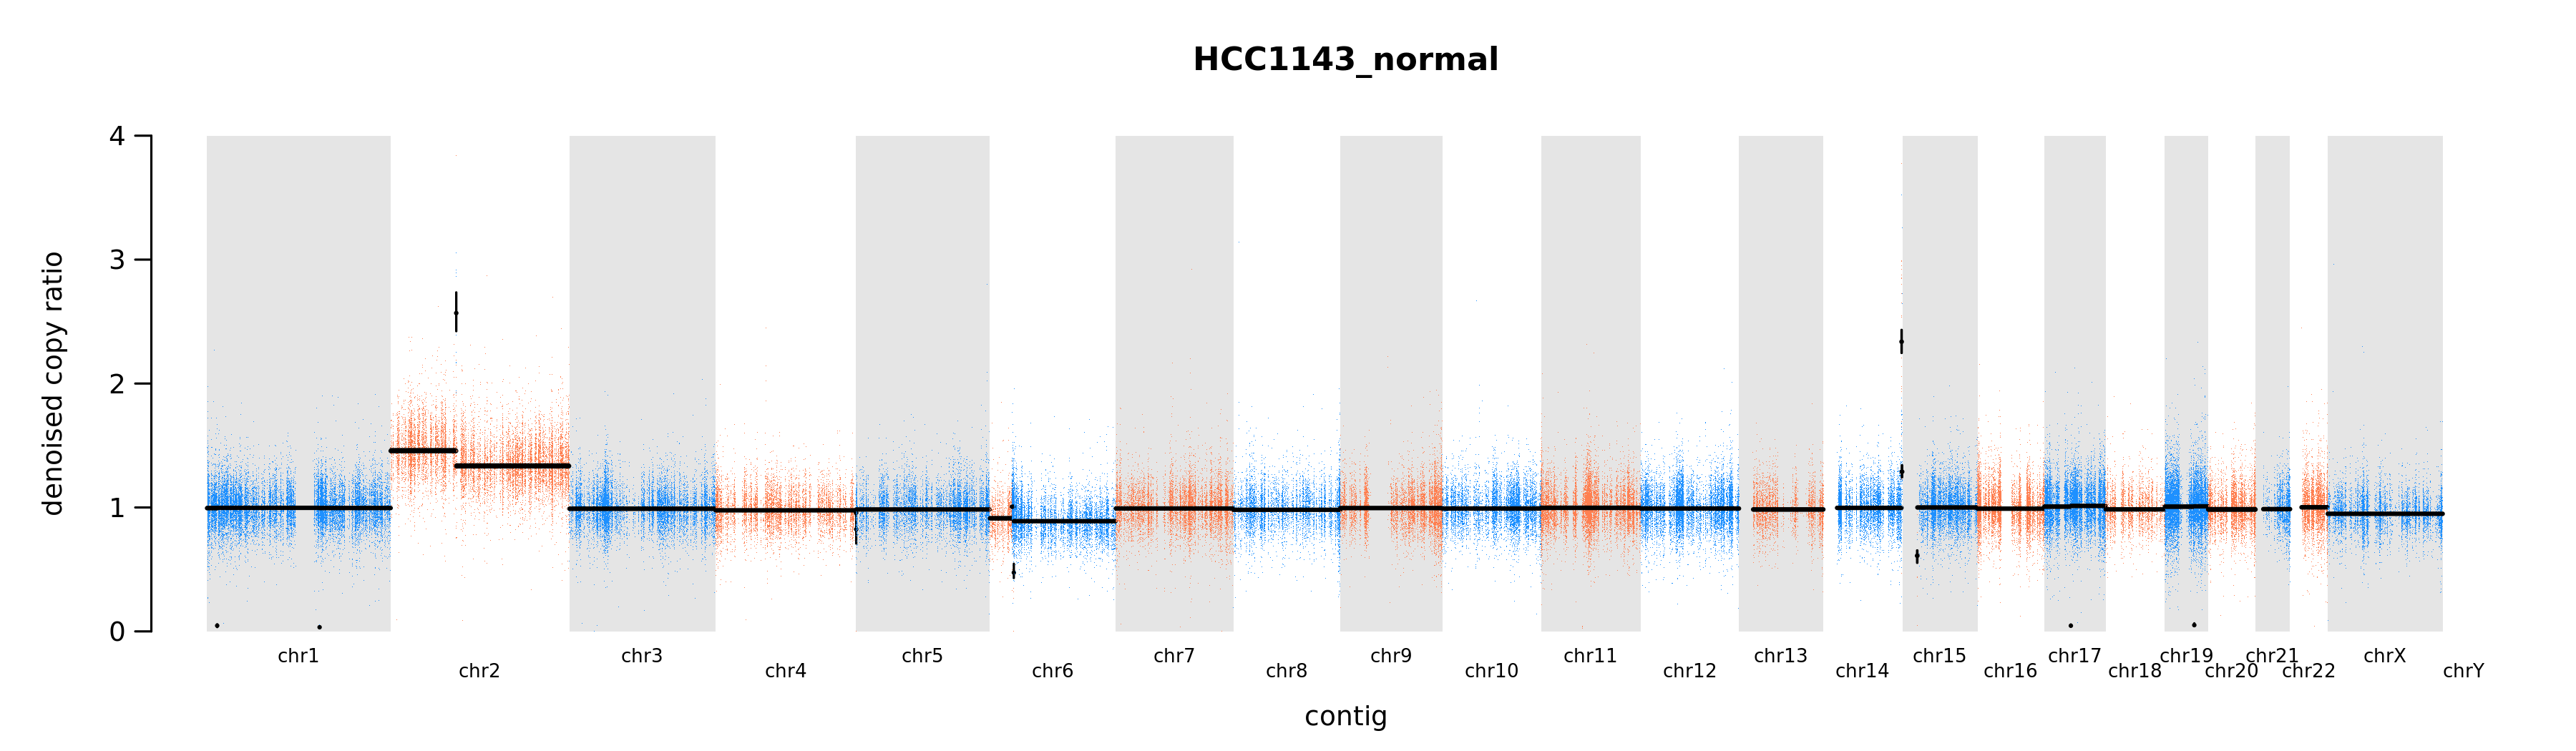

In [28]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_N_clean.modeled.png'))

The command produces a plot with extension .modeled.png, where denoised copy ratios in alternate segments are colored in blue and orange and segment medians are drawn in black. For noisy data, box plots of the available posteriors for each segment become visible. 

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image4.png" alt="drawing" width="900"/>
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image5.png" alt="drawing" width="900"/>

➤ The tumor sample shows a lot of activity. Specifically, it has 234 segments. Is this surprising?
➤ Focus on chr2 of the normal sample. How do you interpret its copy ratio of ~1.3? How about the ~0.9 copy ratio of chr6? 
 
At glance, segments appear to separate into roughly evenly spaced ratios, which represent absolute copy numbers, e.g. 1, 2, 3 and so on. Segments that fall between these likely represent subclonal populations. 

### (Optional) Call Copy Ratio Segments
If you need callsets with amplifications (+), deletions (-) and neutral segments (0) clearly marked, then CallCopyRatioSegments can do this for you. These designations are appended as a new column to the segmented copy-ratio .cr.seg file from ModelSegments.

In [29]:
! gatk CallCopyRatioSegments \
    -I /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.cr.seg \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.called.seg

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CallCopyRatioSegments -I /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.cr.seg -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.called.seg
18:33:06.781 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:33:06.839 INFO  CallCopyRatioSegments - ------------------------------------------------------------
18:33:06.844 INFO  CallCopyRatioSegments - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:33:06.844 INFO  CallCopyRatioSegments - For support and documentation go to https://software.broadinstitute.org/gatk/
18:33:06.844 INFO  CallCopyRatioSegments - Exe

---
# INCORPORATE ALLELIC DATA: MODELSEGMENTS CNA

## Perform segmentation jointly with coverage and allelic data
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image8.July2019.png" alt="drawing" width="35%" align="right" style="margin:0px 20px"/> We just saw what segmentation with coverage data alone looks like. But we can squeeze more juice out of the lemon! In this section, we will model segments using both allelic counts and coverage data for a matched-control case. 

➤ How do allelic counts improve the detection of copy alteration?

Consider in normal germline sequencing, how it is we decide a site's genotype is heterozygous versus homozygous. For a site that is heterozygous, that presents two alleles for a diploid sample, the confidence that the sample has at least two chromosomes is high. A hundred heterozygous sites adjacent to each other becomes strong evidence towards the multi-copy number state of the genomic interval. 

<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image2.July2019.png" alt="drawing" width="50%" align="right" style="margin:20px 20px"/>We can extend this concept further towards detection of a type of zygosity that has implications for cancer. We can take allele counts for sites that are commonly variant in the population. For sites where the normal control is heterozygous, if the tumor sample is homozygous, then we can deduce the tumor underwent loss of heterozygosity (LOH) for the allele. With a string of adjacent LOH sites, we can be confident of an LOH segment. Here, either the tumor simply lost the chromosome segment or underwent a slightly more complicated event called copy-neutral LOH (cnLOH). Coverage data can offer clues towards deducing which type of loss is likely.   

Note it is possible to use allelic counts alone with ModelSegments. Furthermore, the tool will model segments for either a matched case or for a case sample alone. The latter can be useful in revealing clonal subpopulations. 

### Collect allelic counts from pileups (chr17 data)
CollectAllelicCounts tabulates counts of the reference allele and counts of the dominant alternate allele for sites in a given genomic intervals list. The tool filters out reads with MAPQ below 30 and discounts bases with base quality less than 20.
 
We perform this step on the chr17 subset data. In later steps, we will use precomputed results from the full data. Here, theta_snps_paddedC_chr17.vcf.gz contains lifted-over gnomAD SNPs-only sites subset to the padded target regions from section 1. 

In [30]:
! gatk CollectAllelicCounts \
    -L gs://gatk-tutorials/$WORKSHOP/3-somatic/resources/theta_snps_paddedC_chr17.vcf.gz \
    -I gs://gatk-tutorials/$WORKSHOP/3-somatic/bams/tumor.bam \
    -R gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.fasta \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.allelicCounts.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CollectAllelicCounts -L gs://gatk-tutorials/workshop_2002/3-somatic/resources/theta_snps_paddedC_chr17.vcf.gz -I gs://gatk-tutorials/workshop_2002/3-somatic/bams/tumor.bam -R gs://gatk-tutorials/workshop_2002/3-somatic/ref/Homo_sapiens_assembly38.fasta -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.allelicCounts.tsv
18:33:10.866 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:33:10.918 INFO  CollectAllelicCounts - ------------------------------------------------------------
18:33:10.922 INFO  CollectAllelicCounts - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:

In [31]:
! gatk CollectAllelicCounts \
    -L gs://gatk-tutorials/$WORKSHOP/3-somatic/resources/theta_snps_paddedC_chr17.vcf.gz \
    -I gs://gatk-tutorials/$WORKSHOP/3-somatic/bams/normal.bam \
    -R gs://gatk-tutorials/$WORKSHOP/3-somatic/ref/Homo_sapiens_assembly38.fasta \
    -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.allelicCounts.tsv

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar CollectAllelicCounts -L gs://gatk-tutorials/workshop_2002/3-somatic/resources/theta_snps_paddedC_chr17.vcf.gz -I gs://gatk-tutorials/workshop_2002/3-somatic/bams/normal.bam -R gs://gatk-tutorials/workshop_2002/3-somatic/ref/Homo_sapiens_assembly38.fasta -O /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.allelicCounts.tsv
18:34:44.915 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:34:44.973 INFO  CollectAllelicCounts - ------------------------------------------------------------
18:34:44.977 INFO  CollectAllelicCounts - The Genome Analysis Toolkit (GATK) v4.4.0.0
18

The resulting tables notate the read counts for REF and ALT as well as the REF allele and the ALT allele for every site provided in the intervals list.

➤ For sites lacking ALT allele counts, what is in the field for ALT_NUCLEOTIDE?

In [32]:
!grep -v ^@ /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_N_clean.allelicCounts.tsv | head 


CONTIG	POSITION	REF_COUNT	ALT_COUNT	REF_NUCLEOTIDE	ALT_NUCLEOTIDE
chr17	213617	0	0	A	N
chr17	213624	0	0	C	N
chr17	213625	0	0	G	N
chr17	213628	0	0	G	N
chr17	213635	1	0	G	N
chr17	213642	1	0	G	N
chr17	213647	1	0	A	N
chr17	213656	1	0	C	N
chr17	213657	1	0	G	N
grep: write error: Broken pipe




### Model segments jointly on coverage and allelic data (full data)  
In this step, the full spectrum of data converge. We provide precomputed allelic counts from the cna_inputs folder and tumor denoised read counts. Here we use default parameters. Adjusting tool parameters can change the resolution and smoothness of the segmentation results and we recommend researchers tune the parameters for their data.

It is useful to have the matched normal in this case because it makes it easier to detect real heterozygous SNPs.  (Location and counts)

In [33]:
! gatk --java-options "-Xmx7g" ModelSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv \
    --allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.allelicCounts.tsv \
    --normal-allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.allelicCounts.tsv \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox \
    --output-prefix hcc1143_TN_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar ModelSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv --allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.allelicCounts.tsv --normal-allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.allelicCounts.tsv --output /home/jupyter/notebooks/3-somatic-cna/sandbox --output-prefix hcc1143_TN_clean
18:36:06.707 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:36:06.765 INFO  ModelSegments - ------------------------------------------------------------
18:36:06.769 INF

➤ Skim the stdout to get a sense of the preprocessing and analysis. The tool filters sites with total allelic counts less than how many? How many control heterozygous sites does the tool retain? Does the tool then use all of these towards the joint analysis?  
➤ How many segments does the MultidimensionalKernelSegmenter initially find? After smoothing, how many final segments are there? 

The step produces eleven files. See [ModelSegments tool documentation](https://gatk.broadinstitute.org/hc/en-us/articles/4405451294747-ModelSegments) for details. Of note, we have two files with .hets. in the extension, .hets.normal.tsv and .hets.tsv. The former contains the normal control's heterozygous sites. The latter contains the tumor's allele counts for the normal's heterozygous sites. Finally, the .modelFinal.seg file contains the segmentation results.

### Plot coverage copy ratios and alternate allele fractions 
We provide PlotModeledSegments the case sample's denoised copy ratios, .hets allele counts, and final segmentation results. 
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image9.July2019.png" alt="drawing" width="50%" style="margin:20px 20px"/>


In [34]:
! gatk PlotModeledSegments \
    --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv \
    --allelic-counts /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_clean.hets.tsv \
    --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_clean.modelFinal.seg \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots \
    --output-prefix hcc1143_TN_clean

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotModeledSegments --denoised-copy-ratios /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_T_clean.denoisedCR.tsv --allelic-counts /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_clean.hets.tsv --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_clean.modelFinal.seg --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots --output-prefix hcc1143_TN_clean
18:38:33.026 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:38:

View the plot generated from the previous command by running the cell below.

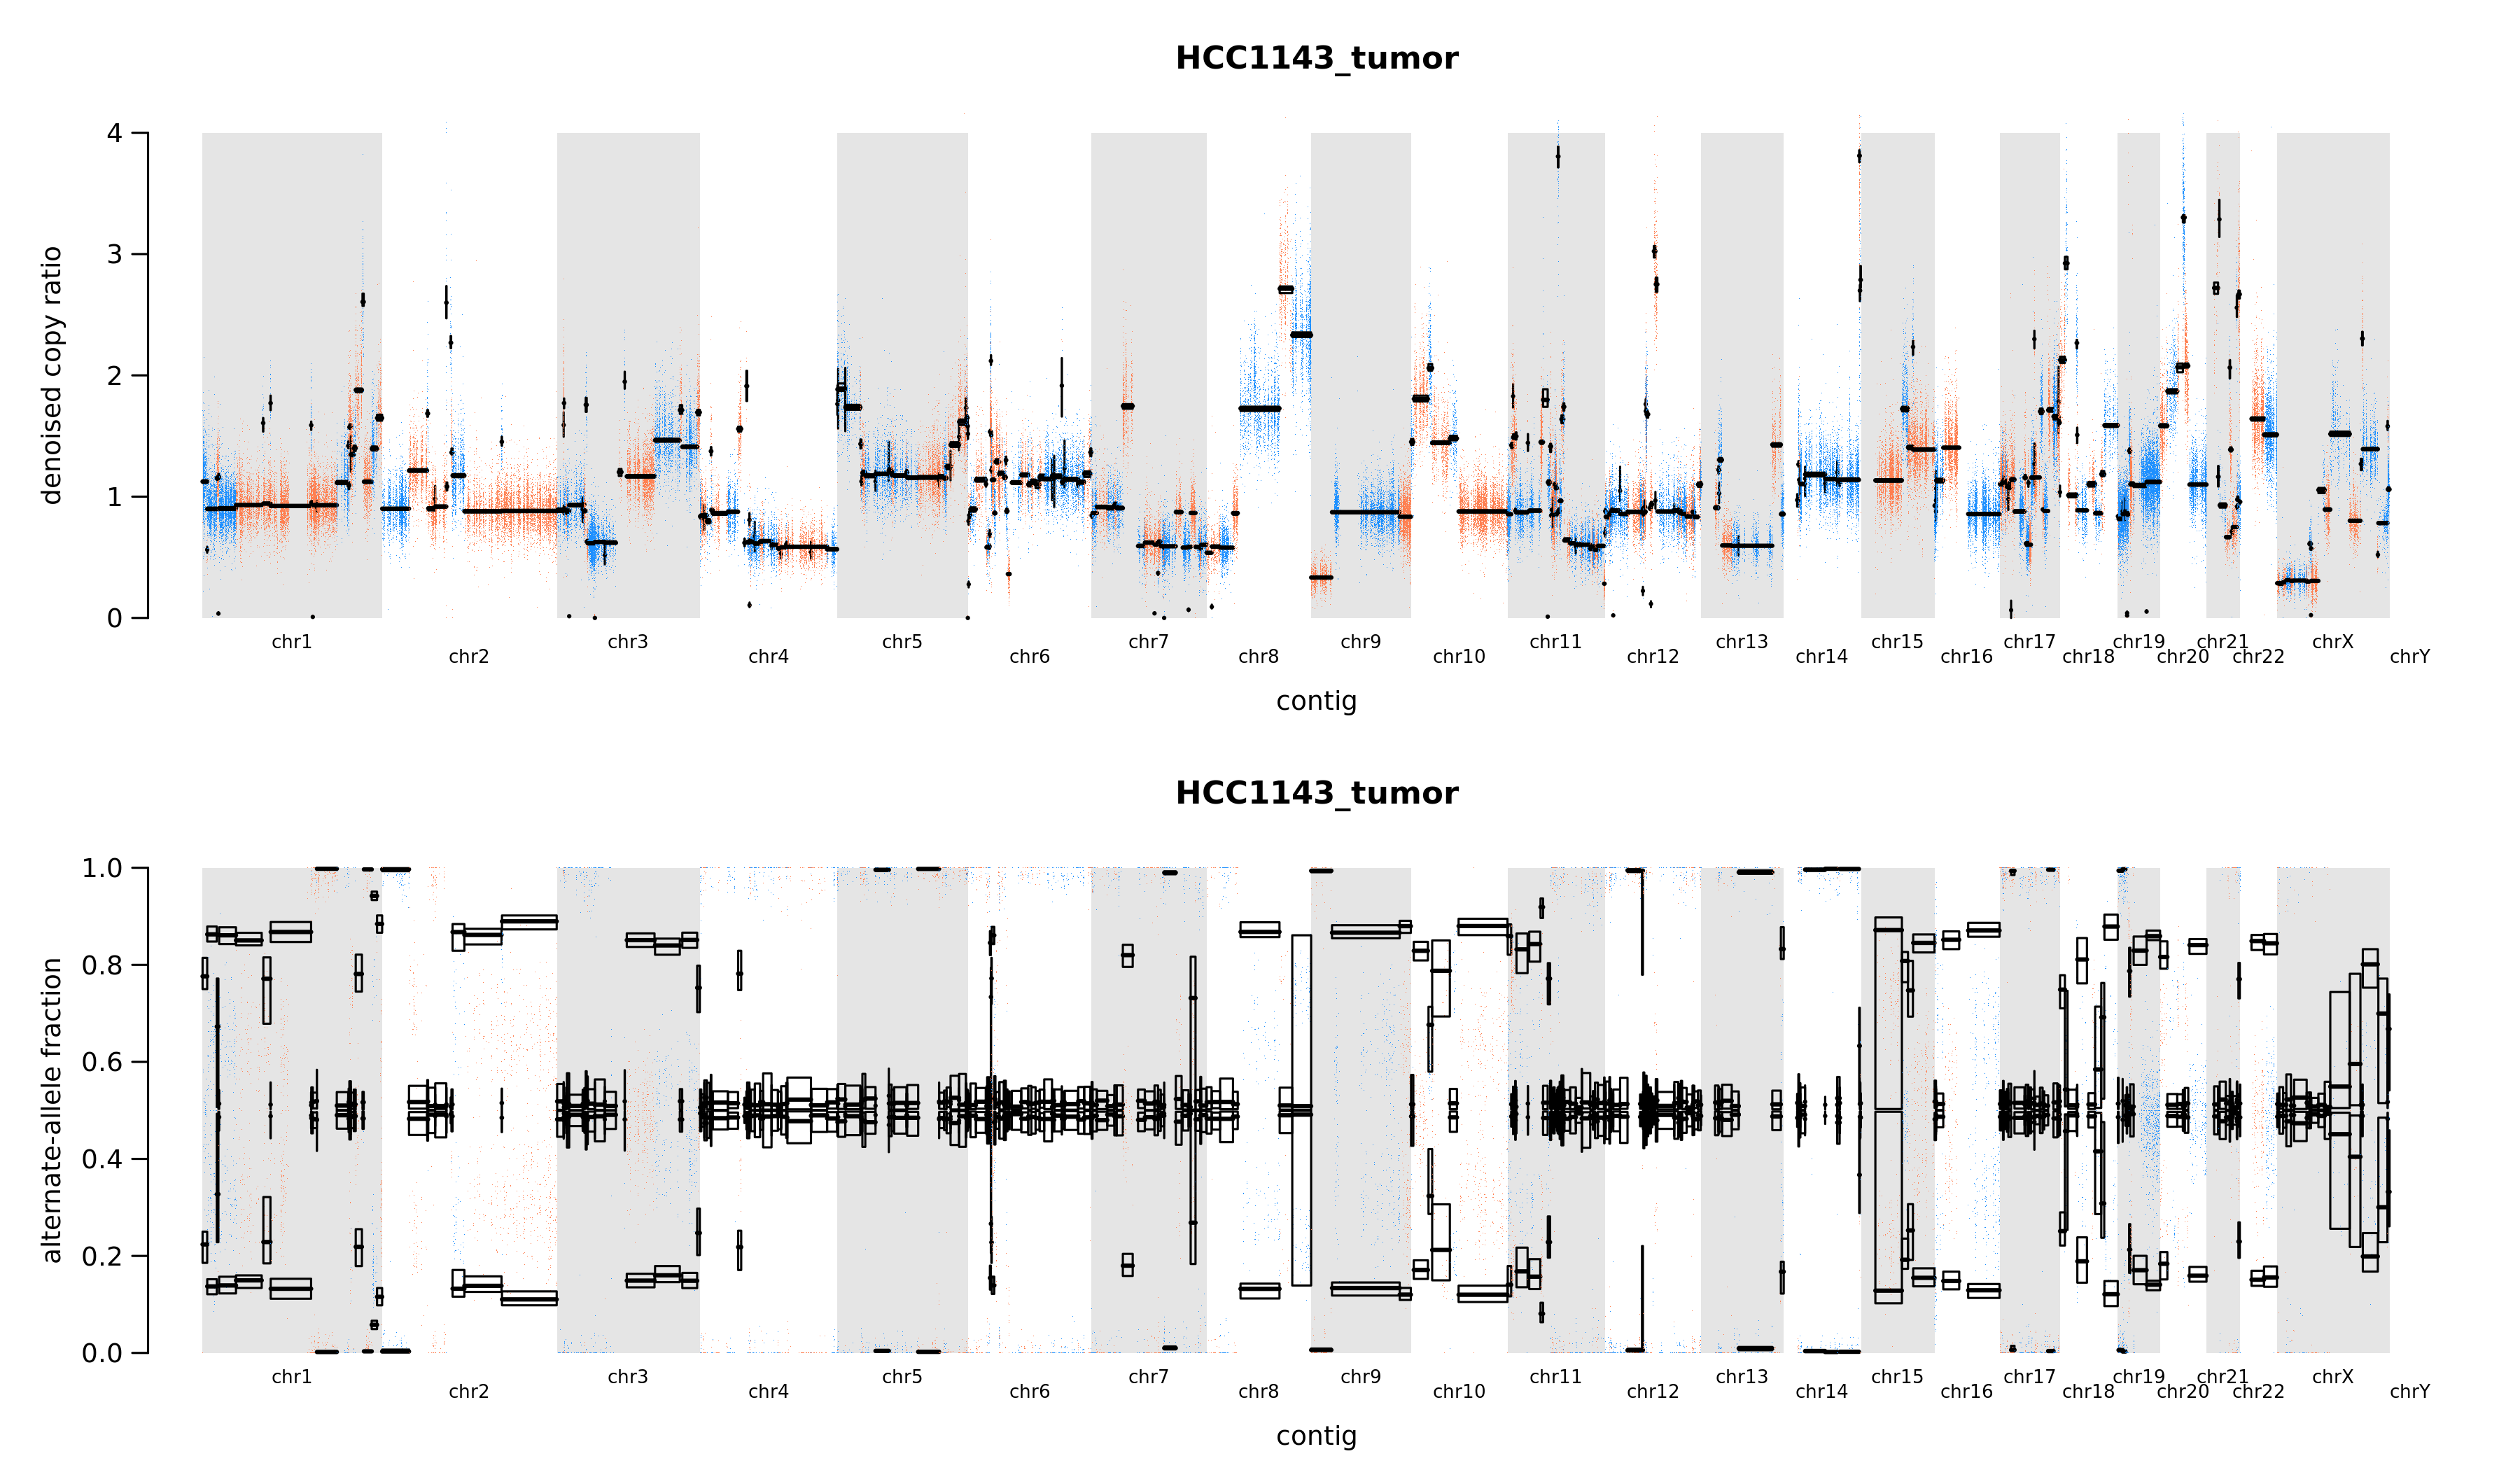

In [35]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_TN_clean.modeled.png'))

This produces a file with two plots, each with 440 segments. The top plot shows segmented copy ratios and the bottom plot shows segmented alternate-allele fractions. Box plots for the major and minor allele fractions mark the 10th, 50th and 90th percentile credible intervals. Vertical streaks appear for very short segments as fewer supporting data points make estimates more uncertain.
<img src="https://storage.googleapis.com/gatk-tutorials/images/3-somatic/somatic-cna-image6.png" alt="drawing" width="900"/>
➤ What do the allelic segments at 0 and 1 indicate? For example, at chr4, chr5 and chr17?

---

## Perform segmentation with allelic data alone
Perform one final comparison. Run ModelSegments and PlotModeledSegments for the matched-case using allelic data alone. 


In [36]:
! gatk --java-options "-Xmx7g" ModelSegments \
    --allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.allelicCounts.tsv \
    --normal-allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.allelicCounts.tsv \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox \
    --output-prefix hcc1143_TN_allelic

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -Xmx7g -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar ModelSegments --allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_T_clean.allelicCounts.tsv --normal-allelic-counts /home/jupyter/notebooks/3-somatic-cna/cna_inputs/hcc1143_N_clean.allelicCounts.tsv --output /home/jupyter/notebooks/3-somatic-cna/sandbox --output-prefix hcc1143_TN_allelic
18:38:41.166 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:38:41.225 INFO  ModelSegments - ------------------------------------------------------------
18:38:41.230 INFO  ModelSegments - The Genome Analysis Toolkit (GATK) v4.4.0.0
18:38:41.231 INFO  ModelSegments - 

In [37]:
! gatk PlotModeledSegments \
    --allelic-counts /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_allelic.hets.tsv \
    --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_allelic.modelFinal.seg \
    --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict \
    --minimum-contig-length 46709983 \
    --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots \
    --output-prefix hcc1143_TN_allelic

Using GATK jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar PlotModeledSegments --allelic-counts /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_allelic.hets.tsv --segments /home/jupyter/notebooks/3-somatic-cna/sandbox/hcc1143_TN_allelic.modelFinal.seg --sequence-dictionary /home/jupyter/notebooks/3-somatic-cna/ref/Homo_sapiens_assembly38.dict --minimum-contig-length 46709983 --output /home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots --output-prefix hcc1143_TN_allelic
18:40:02.225 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/gatk/gatk-4.4.0.0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:40:02.275 INFO  PlotModeledSegments - -----------------------------------------------------------

View the plot generated from the previous command by running the cell below.

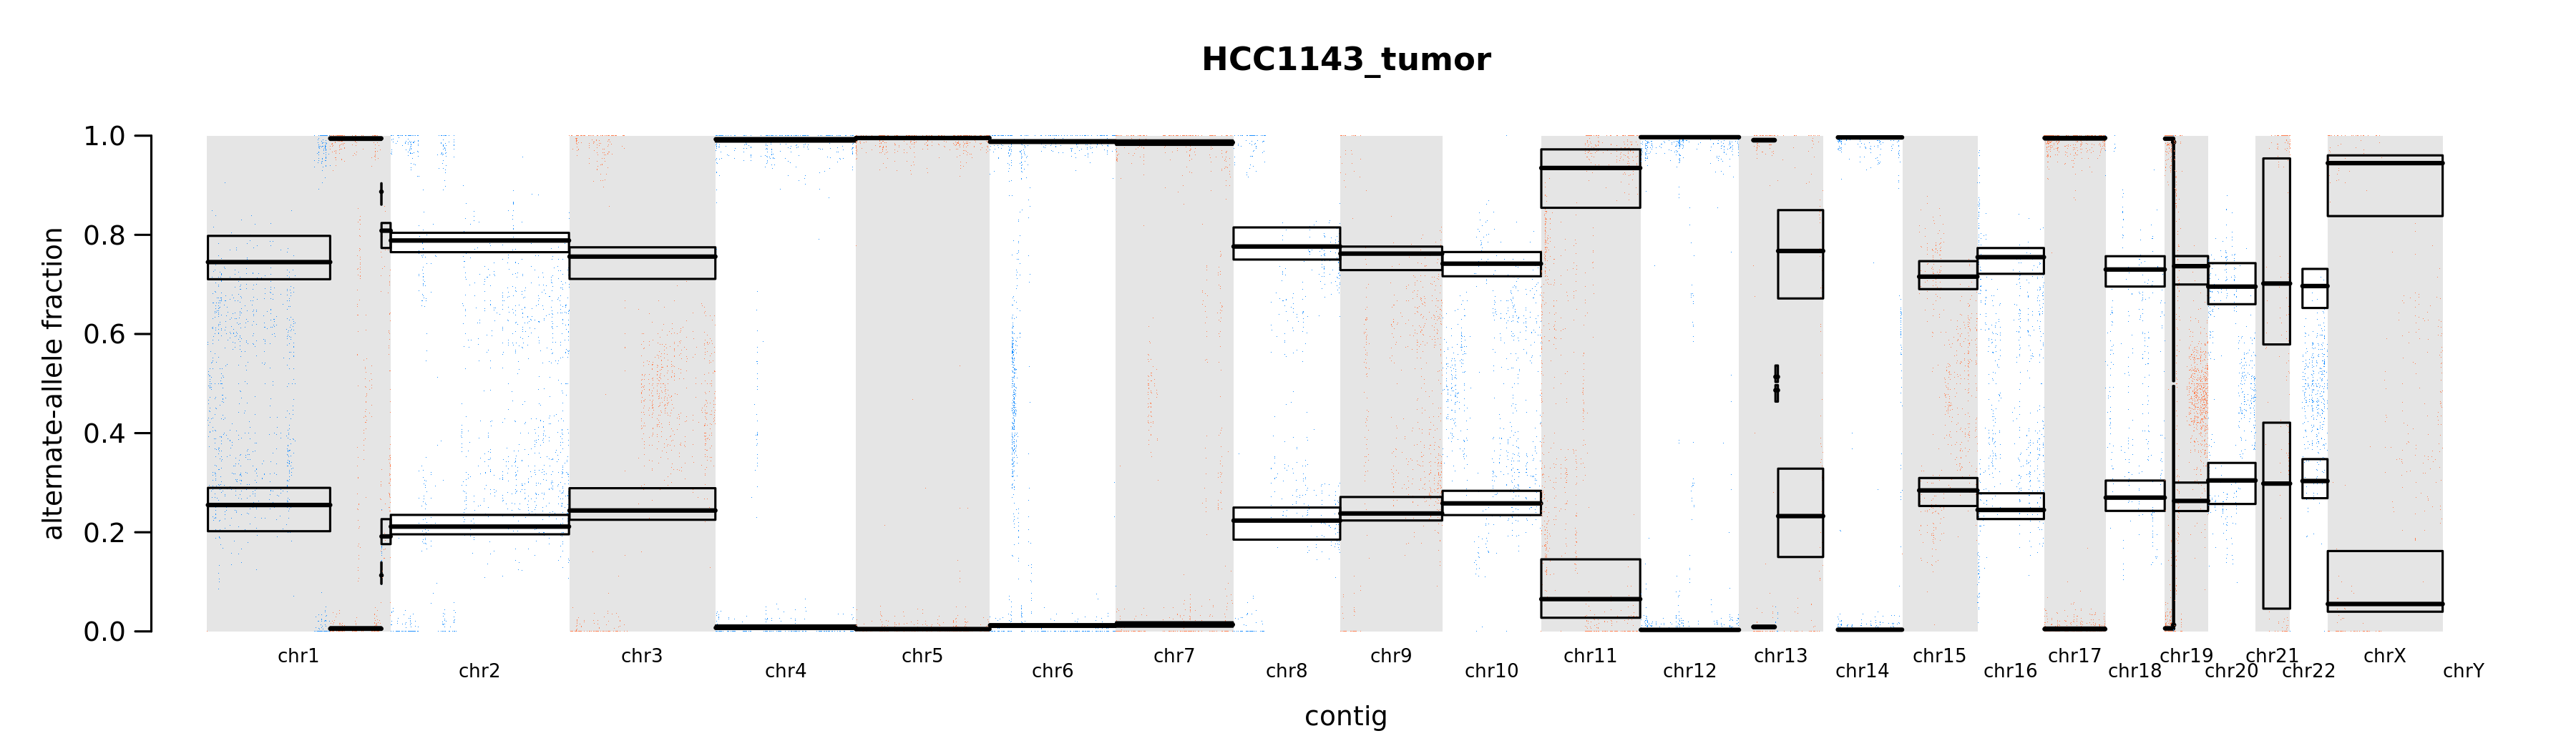

In [38]:
display(Image('/home/jupyter/notebooks/3-somatic-cna/sandbox/cna_plots/hcc1143_TN_allelic.modeled.png'))

This produces an allelic ratios plot with 35 segments. 
<img src="https://storage.googleapis.com/broad-dsde-methods-gatk-workshop-public/images/somatic-cna-tutorial/somatic-cna-image7.png" alt="drawing" width="900"/>
➤ This is more than ~13x less segments than the CR + allelic analysis, and ~7x less than the 234 segments from the copy ratios alone. How do you explain such differences? 

Remember that joint calling groups contiguous segments with the same copy ratio and the same minor allele fraction, for high-resolution results. Finally, remember that the CNA workflow produces copy ratios and not copy numbers. GATK is developing a tool to call absolute somatic copy numbers. For germline absolute copy number detection, see GATK4's [GermlineCNVCaller](https://gatk.broadinstitute.org/hc/en-us/articles/4405451329179-GermlineCNVCaller). 